# Instacart Market Basket Analysis

In [1]:
#!pip install wordcloud cufflinks pyspark

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import time
from scipy import stats
from apyori import apriori
from collections import Counter
from itertools import combinations

from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from pyspark.ml.fpm import FPGrowth
import gc                         
gc.enable()

In [3]:
aisle = pd.read_csv("data/aisles.csv")
aisle.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
departments = pd.read_csv("data/departments.csv")
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
orders = pd.read_csv("data/orders.csv")
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
products = pd.read_csv("data/products.csv")
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
order_products_prior = pd.read_csv("data/order_products__prior.csv")
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
order_products_train = pd.read_csv("data/order_products__train.csv")
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [9]:
order_products = pd.concat([order_products_prior, order_products_train])

order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
orders = pd.read_csv("data/orders.csv")

orders_test = orders[orders['eval_set'] == 'test']

In [11]:
df = pd.merge(orders, order_products, on='order_id')
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [12]:
products = pd.read_csv("data/products.csv")

combined_data = pd.merge(df, products, on='product_id')
combined_data = pd.merge(combined_data, aisle, on='aisle_id')
combined_data = pd.merge(combined_data, departments, on='department_id')
combined_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks,beverages
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,soft drinks,beverages
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,soft drinks,beverages
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,soft drinks,beverages


# EDA

Plot product counts by department

<AxesSubplot:>

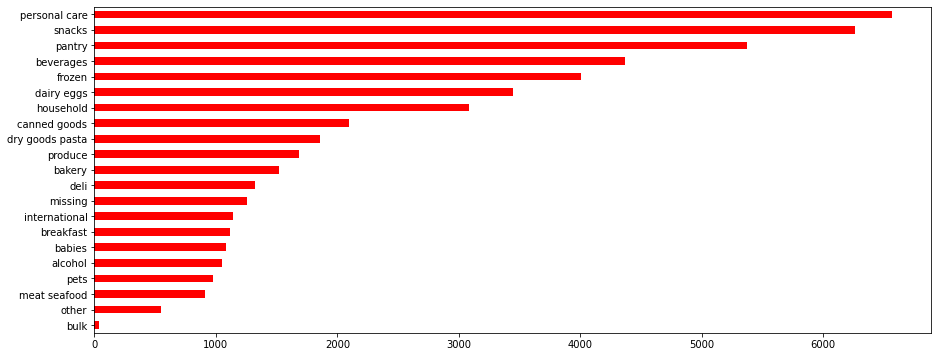

In [13]:
product_by_dept = pd.merge(left=products, right=departments, on='department_id')

plt.figure(figsize=(15,6))

product_by_dept['department'].value_counts().sort_values(ascending=True).plot(kind='barh',color='red')

There are 1581702 words in the combination of all Product Name.


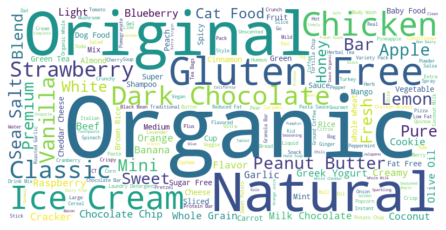

In [14]:
#making of word cloud from Product name column
text = " ".join(topic for topic in product_by_dept.product_name.astype(str))
print ("There are {} words in the combination of all Product Name.".format(len(text)))

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

plt.axis("off")
plt.rcParams["figure.figsize"] = (15,6)
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

<AxesSubplot:xlabel='reordered', ylabel='count'>

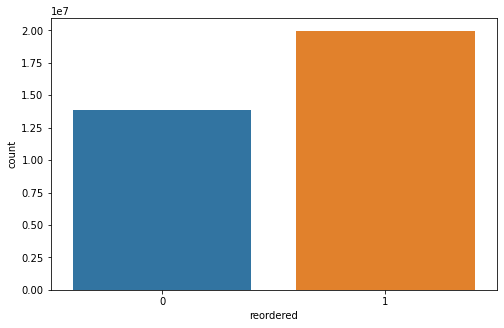

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(x='reordered',data=combined_data)

In [16]:
combined_data['days_since_prior_order'].dropna(inplace= True)

<AxesSubplot:>

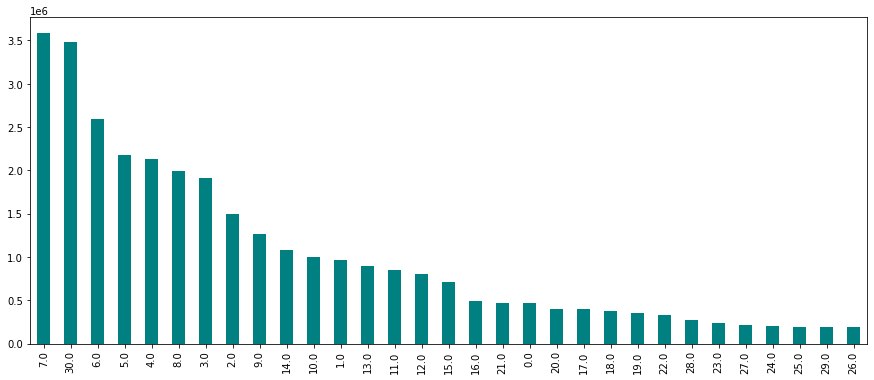

In [17]:
combined_data['days_since_prior_order'].value_counts().sort_values(ascending= False).plot(kind='bar',color='teal')

Plotting what percentage in an order is reorder and how much does it occupy in total order

In [18]:

def percent(x):
    return sum(x)/len(x)*100
order_products.groupby('order_id').agg({'reordered': percent})['reordered'].value_counts(normalize  = True).iloc[:5].iplot(kind = 'bar', 
                                                                             title = 'What Percentage of order is Reorder',
                                                                             xTitle = 'Percentage of reorder in paticular order %',
                                                                             yTitle = 'Percentage of Total order')

In [19]:
aisles_wise_product_add = combined_data.groupby(['reordered', 'aisle']).agg({'product_name' : 'count'}).reset_index()
aisles_wise_product_add = aisles_wise_product_add.pivot('aisle', 'reordered', 'product_name')
aisles_wise_product_add.sort_values(by = [1], axis = 0, ascending = False, inplace = True)
aisles_wise_product_add = aisles_wise_product_add / aisles_wise_product_add.sum() * 100
aisles_wise_product_add.iloc[:20,:].iplot(title = 'How many times were aisles\'s product reordered',
                                           xTitle = 'Top 20 aisles',
                                           yTitle = 'Percentage')

***Most reordered and least reordered product***

In [20]:
reorder_aisle = combined_data.groupby(['aisle', 'department'])['reordered'].mean().to_frame().reset_index()

reorder_aisle.sort_values('reordered', ascending=False)[:5]\
.append(pd.Series('...', index=reorder_aisle.columns), ignore_index=True)\
.append(reorder_aisle.sort_values('reordered', ascending=False)[-5:], ignore_index=True)

,aisle,department,reordered
0,milk,dairy eggs,0.781812
1,water seltzer sparkling water,beverages,0.72993
2,fresh fruits,produce,0.718823
3,eggs,dairy eggs,0.706359
4,soy lactosefree,dairy eggs,0.692361
5,...,...,...
6,beauty,personal care,0.212858
7,first aid,personal care,0.195864
8,kitchen supplies,household,0.194802
9,baking supplies decor,pantry,0.167595


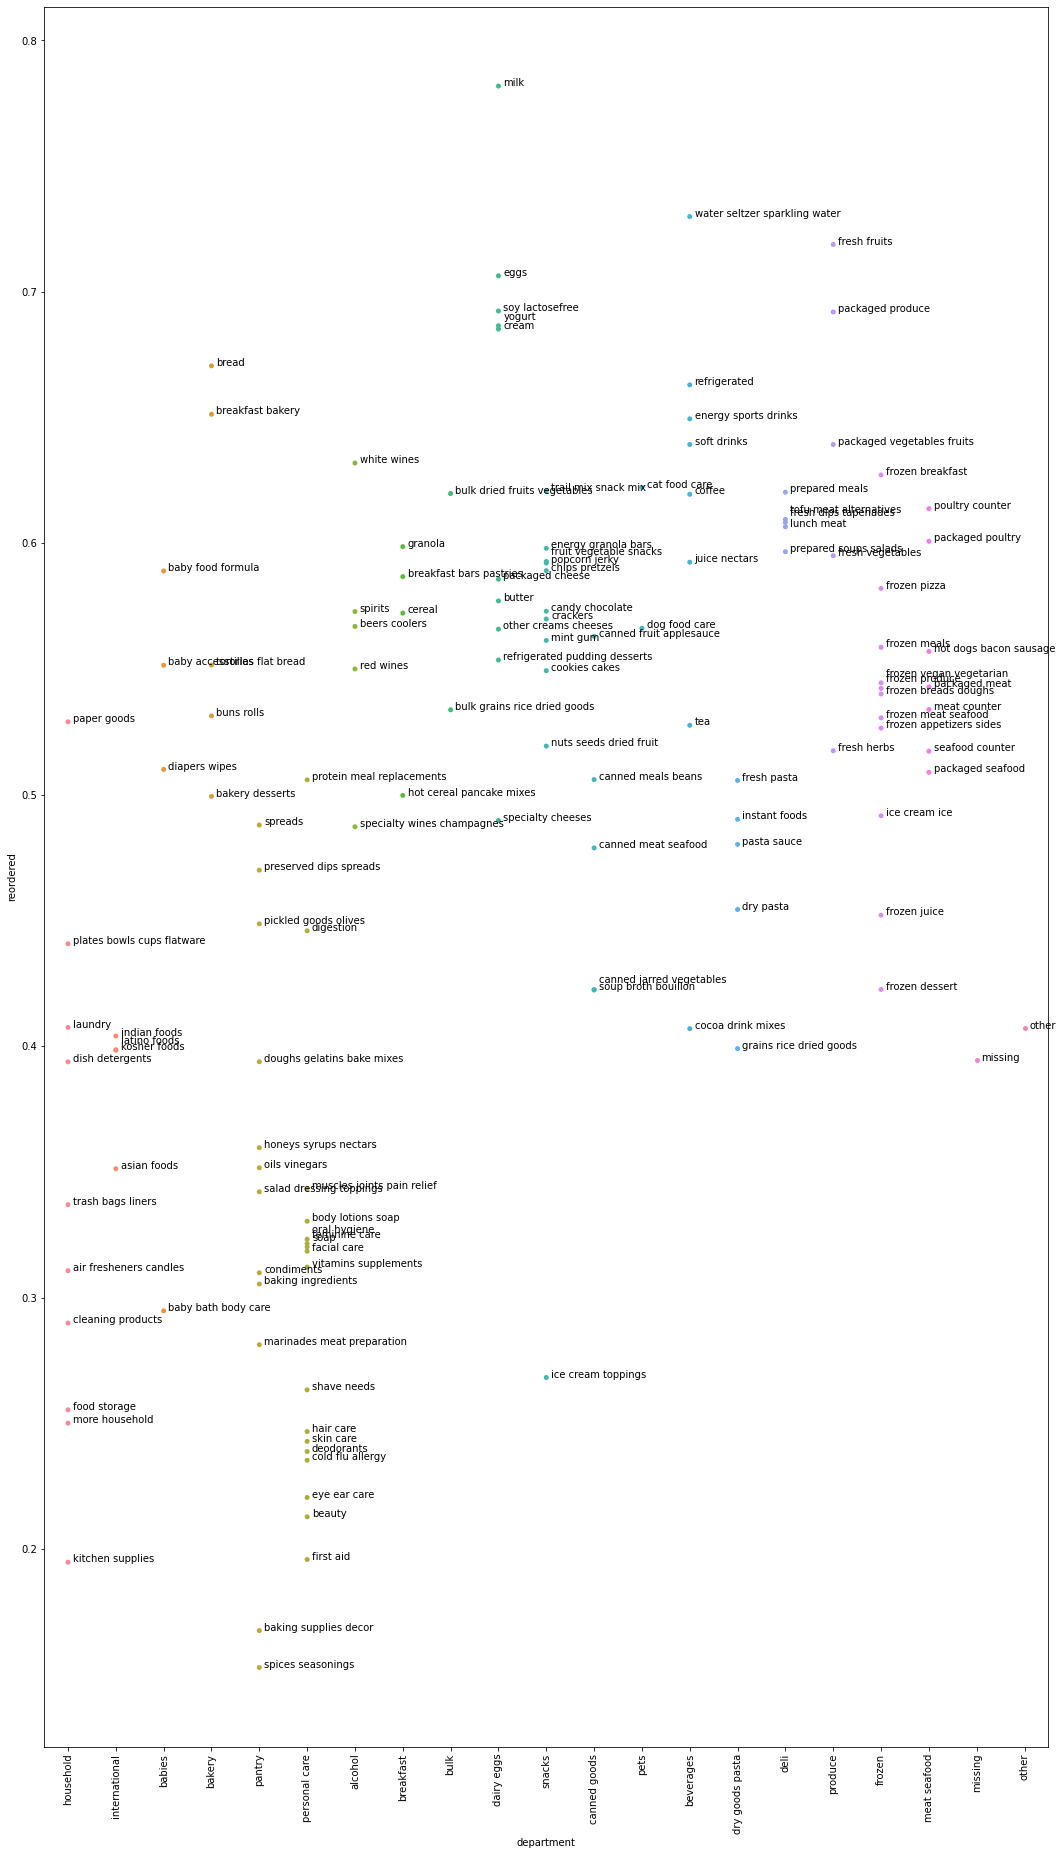

In [21]:

plt.figure(figsize=(18,32))

ax = sns.stripplot(x='department', y='reordered', data=reorder_aisle, jitter=False)

plt.xticks(rotation='vertical')

# Make a list of all department names with the same ordinal values as seaborn plot
dep_cat = reorder_aisle['department'].unique().tolist()

# Annotate with aisle names
for i in range(reorder_aisle.shape[0]):
    # Add some distance for overlapping annotations in the same category. More work necessary for multiple overlapping annotations.
    if (reorder_aisle[reorder_aisle['department'] == reorder_aisle['department'].iloc[i]]['reordered'] \
        - reorder_aisle['reordered'].iloc[i]).between(-0.0025, 0, inclusive=False).any(): 
        ax.annotate(reorder_aisle['aisle'].iloc[i],
                    xy=(dep_cat.index(reorder_aisle['department'].iloc[i]), reorder_aisle['reordered'].iloc[i]),
                    xytext=(dep_cat.index(reorder_aisle['department'].iloc[i])+0.1, reorder_aisle['reordered'].iloc[i]+0.0025))
    else:
        ax.annotate(reorder_aisle['aisle'].iloc[i],
                    xy=(dep_cat.index(reorder_aisle['department'].iloc[i]), reorder_aisle['reordered'].iloc[i]),
                    xytext=(dep_cat.index(reorder_aisle['department'].iloc[i])+0.1, reorder_aisle['reordered'].iloc[i]))

plt.show()

# Train and test data

In [51]:
order_products_pr = pd.merge(order_products_prior, orders, how="inner", on="order_id")
order_products_pr.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [52]:
user = order_products_pr.groupby('user_id')['order_number'].max().to_frame('u_total_orders').reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [53]:
u_reorder = order_products_pr.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio').reset_index()
u_reorder.head()

,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [54]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

user.head()

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


In [55]:
prd = order_products_pr.groupby('product_id')['order_id'].count().to_frame('p_total_purchases').reset_index()
prd.head()

,product_id,p_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [56]:
p_reorder = order_products_pr.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
p_reorder.head()

,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,8,0.503030


In [57]:
prd = prd.merge(p_reorder, on='product_id', how='left')
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)

del p_reorder
gc.collect()

prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.000000


In [58]:
uxp = order_products_pr.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought').reset_index()
uxp.head()

,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [67]:
# get the products and reorder status of the latest purchase of each user #
prior_grouped_df = order_products_pr.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(order_products_pr, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head()

,user_id,product_id,reordered_latest
0,59897,9755,1
1,59897,31487,0
2,59897,37510,1
3,59897,14576,1
4,59897,22105,0


In [68]:
# get the count of each product and number of reorders by the customer #
prior_df_agg = order_products_pr.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head()

,user_id,product_id,reordered_count,reordered_sum
0,1,196,10,9
1,1,10258,9,8
2,1,10326,1,0
3,1,12427,10,9
4,1,13032,3,2


In [69]:
prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge.head()

,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,196,10,9,1.0
1,1,10258,9,8,1.0
2,1,10326,1,0,NaN
3,1,12427,10,9,1.0
4,1,13032,3,2,1.0


In [71]:
# orders = orders.drop(["order_number"],axis=1)

train_df = pd.read_csv("data/order_products__train.csv", usecols=["order_id"])
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head()

,order_id
0,1
1,36
2,38
3,96
4,98


In [72]:
train_df = pd.merge(train_df, orders, how="inner", on="order_id")

train_df = train_df.loc[:,["order_id", "user_id"]]
train_df.head()

,order_id,user_id
0,1,112108
1,36,79431
2,38,42756
3,96,17227
4,98,56463


In [74]:
test_df = pd.read_csv("data/sample_submission.csv", usecols=["order_id"])
test_df = pd.merge(test_df, orders, how="inner", on="order_id")
test_df = test_df.loc[:,["order_id", "user_id"]]
test_df.head()

,order_id,user_id
0,17,36855
1,34,35220
2,137,187107
3,182,115892
4,257,35581


In [75]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,112108,2067,1,0,NaN
1,1,112108,5707,2,1,1.0
2,1,112108,11109,2,1,NaN
3,1,112108,14947,3,2,1.0
4,1,112108,22035,2,1,NaN


In [76]:
test_df = pd.merge(test_df, prior_df_merge, how="inner", on="user_id")
test_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,17,36855,1283,1,0,NaN
1,17,36855,6291,1,0,NaN
2,17,36855,7035,1,0,NaN
3,17,36855,11494,1,0,NaN
4,17,36855,13107,3,2,1.0


In [77]:
products = pd.read_csv("data/products.csv", usecols=["product_id", "aisle_id", "department_id"])

products.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


In [78]:
train_df = pd.merge(train_df, products, how="inner", on="product_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [79]:
test_df = pd.merge(test_df, products, how="inner", on="product_id")
test_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,17,36855,1283,1,0,NaN,100,21
1,657743,16994,1283,1,0,NaN,100,21
2,834223,92628,1283,1,0,NaN,100,21
3,1446886,75870,1283,1,0,NaN,100,21
4,1518981,118458,1283,3,2,NaN,100,21


In [80]:
train_y_df = pd.read_csv("data/order_products__train.csv", usecols=["order_id", "product_id", "reordered"])

train_y_df.head()

,order_id,product_id,reordered
0,1,49302,1
1,1,11109,1
2,1,10246,0
3,1,49683,0
4,1,43633,1


In [81]:
train_y_df = pd.merge(train_y_df, orders, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
train_df.head()

(8474661, 9)


,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,reordered
0,1,112108,2067,1,0,NaN,3,19,0.0
1,96,17227,2067,1,0,NaN,3,19,0.0
2,3243,206024,2067,1,0,NaN,3,19,0.0
3,12950,11456,2067,1,0,0.0,3,19,0.0
4,17683,177724,2067,1,0,NaN,3,19,0.0


In [82]:
train_df = train_df.merge(user, on='user_id', how='left')
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,reordered,u_total_orders,u_reordered_ratio
0,1,112108,2067,1,0,NaN,3,19,0.0,3,0.428571
1,96,17227,2067,1,0,NaN,3,19,0.0,6,0.232558
2,3243,206024,2067,1,0,NaN,3,19,0.0,42,0.620896
3,12950,11456,2067,1,0,0.0,3,19,0.0,9,0.547619
4,17683,177724,2067,1,0,NaN,3,19,0.0,29,0.608586


In [83]:
train_df = train_df.merge(prd, on='product_id', how='left')
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,reordered,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,112108,2067,1,0,NaN,3,19,0.0,3,0.428571,3138,0.606119
1,96,17227,2067,1,0,NaN,3,19,0.0,6,0.232558,3138,0.606119
2,3243,206024,2067,1,0,NaN,3,19,0.0,42,0.620896,3138,0.606119
3,12950,11456,2067,1,0,0.0,3,19,0.0,9,0.547619,3138,0.606119
4,17683,177724,2067,1,0,NaN,3,19,0.0,29,0.608586,3138,0.606119


In [90]:
train_df = train_df.merge(uxp, on=['user_id', 'product_id'], how='left')
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,reordered,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,uxp_total_bought
0,1,112108,2067,1,0,NaN,3,19,0.0,3,0.428571,3138,0.606119,1
1,96,17227,2067,1,0,NaN,3,19,0.0,6,0.232558,3138,0.606119,1
2,3243,206024,2067,1,0,NaN,3,19,0.0,42,0.620896,3138,0.606119,1
3,12950,11456,2067,1,0,0.0,3,19,0.0,9,0.547619,3138,0.606119,1
4,17683,177724,2067,1,0,NaN,3,19,0.0,29,0.608586,3138,0.606119,1


In [ ]:
# delete all unnecessary df

In [91]:
print('Size of training data: ', train_df.shape)

Size of training data:  (8474661, 14)


# Models

In [92]:

tr_data = train_df #i did this step so that I have the independence to do this -> tr_data = train_df.iloc[:10000,:]
print("shape of new train data: ",tr_data.shape)
X=tr_data.drop('reordered',axis=1)
X.head()

shape of new train data:  (8474661, 14)


,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,uxp_total_bought
0,1,112108,2067,1,0,NaN,3,19,3,0.428571,3138,0.606119,1
1,96,17227,2067,1,0,NaN,3,19,6,0.232558,3138,0.606119,1
2,3243,206024,2067,1,0,NaN,3,19,42,0.620896,3138,0.606119,1
3,12950,11456,2067,1,0,0.0,3,19,9,0.547619,3138,0.606119,1
4,17683,177724,2067,1,0,NaN,3,19,29,0.608586,3138,0.606119,1


In [93]:
Y = tr_data['reordered']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [95]:
X_train['reordered_latest'] = X_train['reordered_latest'].replace(np.nan, 0)
X_test['reordered_latest'] = X_test['reordered_latest'].replace(np.nan, 0)

In [96]:
%%time

clfrf = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, oob_score=True)
clfrf.fit(X_train, y_train)

#predictions
predrf = clfrf.predict(X_test)

#accuracy score for the random forest model
print("Accuracy using randomforest classifier: ",accuracy_score(predrf, y_test))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:541: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning:

invalid value encountered in true_divide



Accuracy using randomforest classifier:  0.9073648761960339
CPU times: user 2min 59s, sys: 2.34 s, total: 3min 2s
Wall time: 3min 3s


# Association Rule mining

In [42]:
products = pd.read_csv("data/products.csv")
products_id_to_name = {k: v for k, v in zip(products.product_id, products.product_name)}

In [43]:
order_products = order_products_prior.iloc[0:1000000, :]
order_products

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
999995,105629,18670,9,1
999996,105629,7010,10,1
999997,105629,3142,11,1
999998,105629,28849,12,0


**Apriori Algorithm**

In [44]:
def association_rules(order_products, min_support, min_length = 2, max_length = 5, min_confidence = 0.2, min_lift = 1.0):
    
    print('Loading data...')
    transactions_df = order_products[['order_id', 'product_id']]

    print('Calculating product supports...')
    n_orders = len(set(transactions_df.order_id))
    product_frequency = transactions_df.product_id.value_counts()/n_orders
    products_apriori = product_frequency[product_frequency >= min_support]
    transactions_apriori = transactions_df[transactions_df.product_id.isin(products_apriori.index)]
    
    order_sizes = transactions_apriori.order_id.value_counts()
    orders_apriori = order_sizes[order_sizes >= min_length]
    transactions_apriori = transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
    
    print('Calculating product combinations and supports...')
    
    def product_combinations(transactions_df, max_length = max_length):
        transactions_by_order = transactions_df.groupby('order_id')['product_id']
        max_length_reference = max_length
        for order_id, order_list in transactions_by_order:
            max_length = min(max_length_reference, len(order_list))
            order_list = sorted(order_list)
            for l in range(2, max_length + 1):
                product_combinations = combinations(order_list, l)
                for combination in product_combinations:
                    yield combination
   
    combs = product_combinations(transactions_apriori)
    counter = Counter(combs).items()
    combinations_count = pd.Series([x[1] for x in counter], index = [x[0] for x in counter])
    combinations_frequency = combinations_count/n_orders
    combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
    combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_length]
    
    print('Populating dataframe...')
    A = []
    B = []
    AB = []
    for c in combinations_apriori.index:
        c_length = len(c)
        for l in range(1, c_length):
            comb = combinations(c, l)
            for a in comb:
                AB.append(c)
                b = list(c)
                for e in a:
                    b.remove(e)
                b = tuple(b)
                if len(a) == 1:
                    a = a[0]
                A.append(a)
                if len(b) == 1:
                    b = b[0]
                B.append(b)
            
    apriori_df = pd.DataFrame({'A': A,
                               'B': B,
                               'AB': AB})
    support = {**{k: v for k, v in products_apriori.items()}, 
               **{k: v for k, v in combinations_frequency.items()}}
    apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])
    apriori_df.drop('AB', axis = 1, inplace = True)
    apriori_df['confidence'] = apriori_df.support_AB/apriori_df.support_A
    apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B
    apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
    apriori_df = apriori_df[apriori_df.lift >= min_lift]
    apriori_df = apriori_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)
    
    def convert_product_id_to_name(product_ids):
        if type(product_ids) == int:
            return products_id_to_name[product_ids]
        names = []
        for prod in product_ids:
            name = products_id_to_name[prod]
            names.append(name)
        names = tuple(names)
        return names
    
    apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)

    print('{} rules were generated'.format(len(apriori_df)))

    return apriori_df

In [45]:
%%time
rules = association_rules(order_products, min_support = 0.01)
display(rules.head(20))

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
11 rules were generated


,A,B,support_A,support_B,support_AB,confidence,lift
0,Organic Raspberries,Organic Strawberries,0.042696,0.081987,0.010115,0.236904,2.889544
1,Organic Fuji Apple,Banana,0.027594,0.148690,0.010326,0.374224,2.516803
2,Organic Raspberries,Bag of Organic Bananas,0.042696,0.119555,0.012795,0.299670,2.506548
3,Organic Hass Avocado,Bag of Organic Bananas,0.065998,0.119555,0.019101,0.289421,2.420829
4,Organic Avocado,Banana,0.054191,0.148690,0.016593,0.306191,2.059252
5,Strawberries,Banana,0.044207,0.148690,0.012885,0.291477,1.960294
6,Organic Strawberries,Bag of Organic Bananas,0.081987,0.119555,0.018890,0.230401,1.927156
7,Large Lemon,Banana,0.047350,0.148690,0.012906,0.272553,1.833026
8,Organic Baby Spinach,Bag of Organic Bananas,0.075327,0.119555,0.016049,0.213053,1.782058
9,Organic Strawberries,Banana,0.081987,0.148690,0.017993,0.219464,1.475982


CPU times: user 6.72 s, sys: 436 ms, total: 7.16 s
Wall time: 7.42 s


We can see that Banana is bought more frequently with other Organic food items
Fruits, Vegetables, Greens - The pattern is all these food items are healthy and natural

In [46]:
rules = association_rules(order_products, min_support = 0.002, max_length=3)
with pd.option_context('display.max_colwidth', None):
    display(rules.head(20))

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
210 rules were generated


,A,B,support_A,support_B,support_AB,confidence,lift
0,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.004725,0.005803,0.002196,0.464819,80.100539
1,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,0.005803,0.004725,0.002196,0.378472,80.100539
2,Total 2% Lowfat Greek Strained Yogurt With Blueberry,Total 2% Lowfat Greek Strained Yogurt with Peach,0.006639,0.006317,0.002206,0.332322,52.609652
3,Total 2% Lowfat Greek Strained Yogurt with Peach,Total 2% Lowfat Greek Strained Yogurt With Blueberry,0.006317,0.006639,0.002206,0.349282,52.609652
4,Total 2% Lowfat Greek Strained Yogurt with Peach,Total 2% with Strawberry Lowfat Greek Strained Yogurt,0.006317,0.009601,0.002801,0.443381,46.180499
5,Total 2% with Strawberry Lowfat Greek Strained Yogurt,Total 2% Lowfat Greek Strained Yogurt with Peach,0.009601,0.006317,0.002801,0.291710,46.180499
6,Total 2% with Strawberry Lowfat Greek Strained Yogurt,Total 2% Lowfat Greek Strained Yogurt With Blueberry,0.009601,0.006639,0.002932,0.305352,45.992704
7,Total 2% Lowfat Greek Strained Yogurt With Blueberry,Total 2% with Strawberry Lowfat Greek Strained Yogurt,0.006639,0.009601,0.002932,0.441578,45.992704
8,Yellow Bell Pepper,Orange Bell Pepper,0.007808,0.011606,0.002025,0.259355,22.346841
9,Sparkling Lemon Water,Lime Sparkling Water,0.010044,0.013994,0.002488,0.247743,17.704099


Here these rules show high lift, meaning if one item is purchased, chances of the other item being purchased is very high. Showing that consumers take more than one flavored yogurt and water.

In [47]:
#rules.tail(10)

**FPGrowth Algorithm**

In [49]:
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.master("local[*]").getOrCreate()


In [48]:
order_products = pd.merge(order_products, products, on='product_id')
order_products = order_products[['order_id', 'product_name']]
order_products

,order_id,product_name
0,2,Organic Egg Whites
1,26,Organic Egg Whites
2,120,Organic Egg Whites
3,327,Organic Egg Whites
4,390,Organic Egg Whites
...,...,...
999995,105604,Chocolate Chip French Twists
999996,105605,Juicy Limes
999997,105605,Alcon Naphcon A Eye Drops Eye Allergy Relief
999998,105611,Awapuhi Ginger Shampoo


In [50]:
sparkdata = spark.createDataFrame(order_products)
sparkdata

DataFrame[order_id: bigint, product_name: string]

In [51]:
basketdata = sparkdata.groupBy("order_id").agg(F.collect_list("product_name"))
basketdata

DataFrame[order_id: bigint, collect_list(product_name): array<string>]

In [52]:
%%time
fpGrowth = FPGrowth(itemsCol="collect_list(product_name)", minSupport=0.01, minConfidence=0.01)
model = fpGrowth.fit(basketdata)


CPU times: user 41.7 ms, sys: 25.6 ms, total: 67.3 ms
Wall time: 20.8 s


In [53]:
# Display frequent itemsets.
# model.freqItemsets.show()
items = model.freqItemsets
# Display generated association rules.
# model.associationRules.show()
rules = model.associationRules
# transform examines the input items against all the association rules and summarize the consequents as prediction
# model.transform(basketdata).show()
transformed = model.transform(basketdata)

In [54]:
items_pdf = items.select("*").toPandas()
items_pdf.head(20)

,items,freq
0,[Banana],14759
1,[Bag of Organic Bananas],11867
2,[Organic Strawberries],8138
3,"[Organic Strawberries, Bag of Organic Bananas]",1875
4,"[Organic Strawberries, Banana]",1786
5,[Organic Baby Spinach],7477
6,"[Organic Baby Spinach, Organic Strawberries]",1180
7,"[Organic Baby Spinach, Bag of Organic Bananas]",1593
8,"[Organic Baby Spinach, Banana]",1616
9,[Organic Hass Avocado],6551


In [55]:
rules_pdf = rules.select("*").toPandas()
rules_pdf.head(20)

,antecedent,consequent,confidence,lift,support
0,[Bag of Organic Bananas],[Organic Strawberries],0.158001,1.927156,0.018890
1,[Bag of Organic Bananas],[Organic Baby Spinach],0.134238,1.782058,0.016049
2,[Bag of Organic Bananas],[Organic Hass Avocado],0.159771,2.420829,0.019101
3,[Bag of Organic Bananas],[Organic Raspberries],0.107019,2.506548,0.012795
4,[Banana],[Organic Strawberries],0.121011,1.475982,0.017993
5,[Banana],[Organic Baby Spinach],0.109493,1.453554,0.016280
6,[Banana],[Organic Hass Avocado],0.070398,1.066658,0.010467
7,[Banana],[Organic Avocado],0.111593,2.059252,0.016593
8,[Banana],[Large Lemon],0.086794,1.833026,0.012906
9,[Banana],[Strawberries],0.086659,1.960294,0.012885


In [58]:
transformed_pdf = transformed.select("*").toPandas()
with pd.option_context('display.max_colwidth', None):
  display(transformed_pdf.head(20))

,order_id,collect_list(product_name),prediction
0,26,"[Organic Unsweetened Almond Milk, Red Grapefruit, Boneless Skinless Chicken Breasts, Berry Medley, Organic Baby Spinach, Banana, Organic Avocado, Organic Egg Whites]","[Organic Strawberries, Organic Hass Avocado, Large Lemon, Strawberries, Organic Fuji Apple, Bag of Organic Bananas]"
1,29,"[Raspberries, Smartwater, Baby Cucumbers, Sinfully Sweet Campari Tomatoes, Bag of Organic Bananas]","[Organic Strawberries, Organic Baby Spinach, Organic Hass Avocado, Organic Raspberries]"
2,964,"[Green Bell Pepper, Organic Diced Tomatoes, Kids Sensible Foods Broccoli Littles, Organic Cottage Cheese, Organic Stage 2 Peaches & Bananas Baby Food, Organic Cannellini Beans, Organic Pumpkin, Organic Pears, Peas and Broccoli Puree Stage 1, Organic 4 Months Butternut Squash Carrots Apples + Prunes Baby Food, Grovestand Lots of Pulp Orange Juice]",[]
3,1677,"[Original Almondmilk, 0% Greek Strained Yogurt]",[]
4,1697,"[Iceberg Lettuce, Unsalted Pure Irish Butter, Heavy Whipping Cream, Organic Dill, Romaine Hearts, Ready-to-Bake 9 Inch Pie Crusts, Organic White Onions, Organic Green Leaf Lettuce, Goat Cheese Log, Ginger Ale Jamaican Style, 8\"" Apple Pie, Brownberry Natural Wheat Bread, Thai Peanut Sauce, Pure, All-Natural Clam Juice, Chicken Base, Organic, Chopped Clams, Organic Avocado, Organic Half & Half]",[Banana]
5,1806,[Direct Trade Black Cat Classic Espresso Roast Whole Bean Coffee],[]
6,1950,"[Milk, Organic, Vitamin D, 100% Recycled Paper Towels]",[]
7,2040,"[Organic Blackberries, Total 0% Nonfat Greek Yogurt, ALMONDBREEZE UNSWEETENED, Hazelnuts, Cheddar Cheese Medium, Bag of Organic Bananas, Organic Raspberries, Vanilla Almond Breeze Almond Milk]","[Organic Strawberries, Organic Baby Spinach, Organic Hass Avocado]"
8,2214,"[Raspberries, Tilapia Filet, Limes, Hass Avocados, Fresh Ginger Root, Kale Greens, Russet Potato, No Pulp Calcium & Vitamin D Pure Premium 100% Pure Orange Juice, Organic Navel Orange, Green Onions, Raspberry Yoghurt, Tomato Paste, Organic Blueberry Waffles, Blueberry Yoghurt, 93% Ground Beef, Organic Broccoli Slaw, Yellow Onions, Organic Whole Milk]",[]
9,2250,"[Squeeze Real Mayonnaise, Raisin Bran Cereal, Lavender Dish Soap, Bagel Bites Three Cheese Mini Bagel Pizzas, Multigrain Tortilla Chips, Everyday 2 Ply Premium Napkins, Organic Pack Peasant Bread, Pink Virgin Lemonade, Sweetened Light Whipped Cream, Orange Juice with Calcium, Dry Roasted Lightly Salted Peanuts, Sweet Pea and Violet Body Wash, Frosted Flakes Cereal, Fruity Cheerios Cereal, Post Selects Great Grains Cereal Raisins, Dates and Pecans, Great Grains, Banana]","[Organic Strawberries, Organic Baby Spinach, Organic Hass Avocado, Organic Avocado, Large Lemon, Strawberries, Organic Fuji Apple]"
